# Imports

In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import warnings
import logging
import keras_tuner
import shutil

tfk = tf.keras
tfkl = tf.keras.layers

# Setting trial parameters

In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [3]:
val_split = 0.25
batch_size = 128
epochs = 1000

# Data

## Import dataset

In [4]:
X = np.load("/kaggle/input/multivariatetimeseriesclassification/x_train.npy")
Y = np.load("/kaggle/input/multivariatetimeseriesclassification/y_train.npy")

n_labels = len(np.unique(Y))

total_n_samples = X.shape[0]
n_ticks = X.shape[1]
n_dim = X.shape[2]

## Make train-val split

In [5]:
n_train = round(total_n_samples * (1 - val_split))

shuffled_idx = np.random.permutation(total_n_samples)

train_idx = shuffled_idx[:n_train]
val_idx = shuffled_idx[n_train:]

train_X = X[train_idx]
train_Y = Y[train_idx]

val_X   = X[val_idx]
val_Y   = Y[val_idx]

train_Y = tfk.utils.to_categorical(train_Y)
val_Y = tfk.utils.to_categorical(val_Y)

# Use KerasTuner for hyperparameter tuning
## Define the model-building function with the appropriate search space
Below is defined the function that builds the model with variables belonging to the KerasTuner optimizer's search space defined using the `hp` object passed as the function argument. This argument represents a `Tuner` object from `KerasTuner`'s API.

The `hp.Choice(...)` method offers the Tuner different options to choose from a finite set of values to give to a certain variable, according to the Tuner's optimization paradigm (*bayesian*, *grid search*, *random search*, ...).   
The `hp.Float(...)`, however, defines a continous search interval for a given variable. This is used in finding the appropriate percentage of Dropout.

The parameter sampling is done at runtime, dynamically. This means that we can sample a parameter "number of layers" then sample the according number of "number of neuron" parameters, for instance.

In [6]:
def build_tune_model(hp):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=(n_ticks, n_dim), name='Input')
    
    n_blocks = hp.Choice('n_blocks', [2, 3])  # Number of convolutional blocks (conv layer + pooling)
    conv_filter_size = 3  # Kernel width (the number of contiguous inputs from the sequence treated simultaneously)
    padding = 'same'  # padding method for the Keras' Conv1D layers
    classif_layers = hp.Choice('classif_layers', [1, 2, 3])  # Number of dense layers to add on top of the convolutional pipe
    
    powers2 = np.power(2, np.arange(5, 9))  # List of powers of 2 to choose from, for each layer's number of units

    # --- Feature extractor ---
    # Let the tuner sample the right depth for the first convolutional kernel
    base_n_filters = hp.Choice('base_n_filters', [int(x) for x in powers2])
    cnn = tfkl.Conv1D(base_n_filters,conv_filter_size,padding=padding,activation='relu')(input_layer)
    cnn = tfkl.MaxPooling1D()(cnn)
    
    last_size = base_n_filters
    
    # Find the optimal kernel depth (filters) for each and every one of the convolutional layers
    for block in range(1, n_blocks):
        n_filters = hp.Choice('n_filter%d' % block, [int(x) for x in powers2[powers2 >= last_size]])
        cnn = tfkl.Conv1D(n_filters,conv_filter_size,padding=padding,activation='relu')(cnn)
        last_size = n_filters
    
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    
    # Find the optimal percentage of the resulting feature vector to drop out
    dropout = tfkl.Dropout(hp.Float('feature_dropout_rate', 0.25, 0.5), seed=seed)(gap)

    # --- Classifier ---
    # Find the optimal number of units (neurons), and dropout rate, for each and every one of the dense, classifying layers
    classifier = tfkl.Dense(hp.Choice('classif%d_units' % 0, [int(x) for x in powers2]), activation='relu')(dropout)
    classifier = tfkl.Dropout(hp.Float('dropout0', 0., 0.3), seed=seed)(classifier)
    for layer in range(classif_layers):
        classifier = tfkl.Dense(hp.Choice('classif%d_units' % layer, [int(x) for x in powers2]), activation='relu')(classifier)
        classifier = tfkl.Dropout(hp.Float('dropout%d' % layer, 0., 0.3), seed=seed)(classifier)
                            
    output_layer = tfkl.Dense(n_labels, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [7]:
# Define the Tuner object from the model-building function defined above
tuner = keras_tuner.BayesianOptimization(
    build_tune_model,
    objective='val_accuracy',
    max_trials=100)

2022-12-12 18:40:05.734876: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-12 18:40:05.891014: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-12 18:40:05.892176: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-12 18:40:05.893944: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [8]:
# Run the search, using the same parameters as you would use with the Model.fit(...) method
tuner.search(
    train_X,
    train_Y,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(val_X, val_Y),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=100, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=50, factor=0.5, min_lr=1e-5)
    ]

Trial 100 Complete [00h 00m 35s]
val_accuracy: 0.7100494503974915

Best val_accuracy So Far: 0.7512356042861938
Total elapsed time: 01h 23m 39s


In [14]:
# Retrieve best-performing model and the corresponding hyperparameters so that we can rebuild it
best_model = tuner.get_best_models()[0]
best_hp = tuner.get_best_hyperparameters()[0]
print(best_hp.values)

{'n_blocks': 2, 'classif_layers': 1, 'base_n_filters': 64, 'n_filter1': 256, 'feature_dropout_rate': 0.4063132966650767, 'classif0_units': 256, 'dropout0': 0.0, 'classif1_units': 256, 'dropout1': 0.3, 'n_filter2': 256, 'classif2_units': 32, 'dropout2': 0.1936799501743576}


In [21]:
# Save the Tuner object, containing the search logs, trials, and all
import joblib
joblib.dump(tuner, "conv1d_tuner")

['conv1d_tuner']

In [12]:
# Save the best model
best_model.save("tuned_conv1D")
shutil.make_archive("tuned_conv1D", 'zip', "tuned_conv1D")

2022-12-12 20:09:12.322079: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


'/kaggle/working/tuned_conv1D.zip'

'n_blocks': 2, 'classif_layers': 1, 'base_n_filters': 64, 'n_filter1': 256, 'feature_dropout_rate': 0.4063132966650767, 'classif0_units': 256, 'dropout0': 0.0, 'classif1_units': 256, 'dropout1': 0.3, 'n_filter2': 256, 'classif2_units': 32, 'dropout2': 0.1936799501743576

# Re-build the model with the best found hyperparameters and train it from scratch again
We can rebuild the model with the hyperparamaters we found during the search. `KerasTuner` actually recommends to do so or it could cause problems during inference. Also, once you found a good model that is not too prone to overfitting, you can actually throw away the validation data and train using ALL the given data (I didn't do that, though).

In [35]:
tuned_model = tuner.hypermodel.build(best_hp)
tuned_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 36, 6)]           0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 36, 64)            1216      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 18, 64)            0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 18, 256)           49408     
_________________________________________________________________
global_average_pooling1d_8 ( (None, 256)               0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 256)               65792 

## Seed optimization
We know the model performed with accuracy >.75 during the hyperparameter search. But it could underperform depending on the stochastic processes. We will re-build, re-compile and re-train the model from scratch until we get good enough (not underperforming too much) results...  

N.B:
- Instead of a `while` loop, it would have been better to just run the loop for a fixed number of iterations (=10, 15, 20, 30, 0...).
- To be fair, this kind of optimization is  beyond fine-tuning and could be seen as a somewhat cheap way to get slightly better results in the context of the challenge.

In [ ]:
model_good = False
while model_good is False:
    tuned_model = tuner.hypermodel.build(best_hp)
    history = tuned_model.fit(
        train_X,
        train_Y,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(val_X, val_Y),
        callbacks = [
            tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=100, restore_best_weights=True),
            tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=50, factor=0.5, min_lr=1e-5)
        ]
    ).history
    model_good = (tuned_model.evaluate(val_X, val_Y, verbose=0)[1] > 0.73)

## Plot training

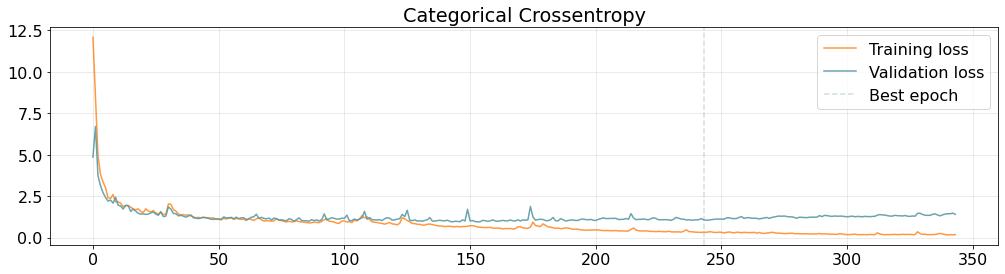

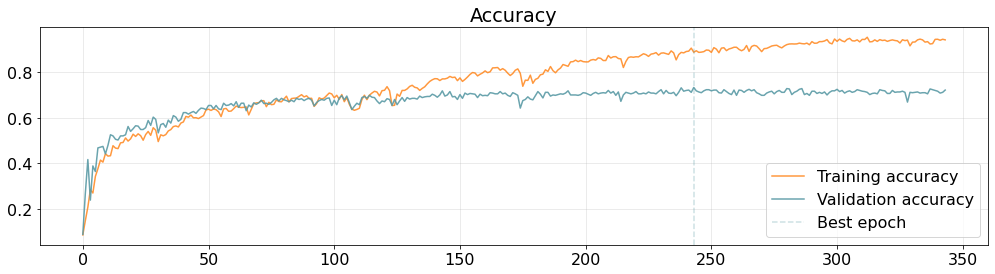

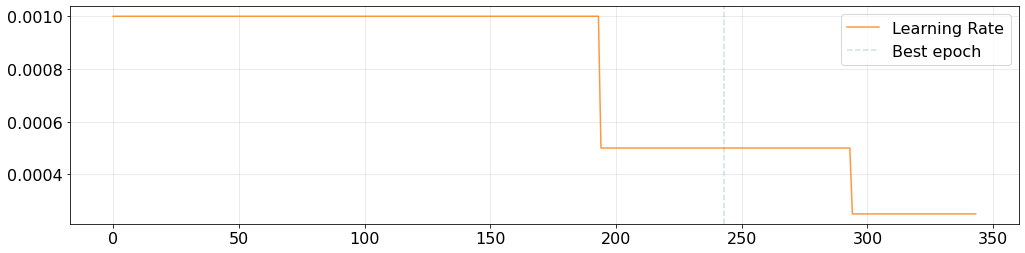

In [19]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [40]:
tuned_model.save("tuned_conv1D")
shutil.make_archive("tuned_conv1D", "zip", "tuned_conv1D")

'/kaggle/working/tuned_conv1D.zip'